In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm

# Load Data
gene, taxon profile sizes and the similarity scores for eah pair

In [2]:
def load_data():
	
    input = pd.read_csv('../../data/real_data_experiment/experiment/results/random_scores_sizes_filtered.tsv',\
                           sep='\t', header=0)
#     inFile = open("../../data/real_data_experiment/experiment/results/random_scores_sizes.tsv")
    
    scores = input['Median nIC']
    gene_profile_sizes = input['gene_size']
    taxon_profile_sizes = input['taxon_size']
    
#     scores = []
#     gene_profile_sizes = []
#     taxon_profile_sizes = []

#     for line in inFile:
#         if "Score" not in line:
#             data = line.strip().split("\t")
#             score = float(data[3])
#             scores.append(score)
#             gene_profile_sizes.append(int(data[1]))
#             taxon_profile_sizes.append(int(data[4]))
#     inFile.close()
    
    return scores, gene_profile_sizes, taxon_profile_sizes

In [3]:
scores, gene_profile_sizes, taxon_profile_sizes = load_data()
gene_taxon_scores = pd.DataFrame(
    {
        'gene': gene_profile_sizes,
        'taxon': taxon_profile_sizes,
        'scores': scores
    })

# Generate average similarity scores

We will compute the average score for each pair (gene_size, taxon_size), in order to manipulate data easily and have clearer view of how the data looks, since multiple pairs genes and taxons with same profile sizes can have same similarity scores.

In [4]:
def generate_avg_scores(gene_taxon_scores):

    if len(gene_taxon_scores) == 0:
        print('missing values for scores/taxon profile sizes/gene profile sizes')
        return

    gene_taxon_scores = gene_taxon_scores.groupby(['taxon','gene'], as_index=False)['scores'].mean() 
    gene_taxon_scores.rename(columns={'scores':'avg_scores'}, inplace=True)    
    print(gene_taxon_scores.head())
    return gene_taxon_scores

In [5]:
gene_taxon_avg_scores = generate_avg_scores(gene_taxon_scores)

   taxon  gene  avg_scores
0      3     1    0.021177
1      3     2    0.017992
2      3     3    0.017392
3      3     4    0.017783
4      3     5    0.018347


# Data Transformation

1. Log Transformations
We will obtain the log for taxon/gene profile sizes, similarity score. These values will be used later in multiple linear regressions. 

2. Box Cox - power transformation
This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like.

## 1. Log Transformation

Gene Logarithm, Taxon Logarithm, Average scores

In [6]:
geneLog = gene_taxon_avg_scores['gene'].apply(np.log)
taxonLog = gene_taxon_avg_scores['taxon'].apply(np.log)

geneLog_taxonLog_avg_scores = gene_taxon_avg_scores.copy(deep=True)
geneLog_taxonLog_avg_scores.rename(columns={'gene':'geneLog', 'taxon':'taxonLog'}, inplace=True)   
geneLog_taxonLog_avg_scores['geneLog'] = geneLog
geneLog_taxonLog_avg_scores['taxonLog'] = taxonLog
print(geneLog_taxonLog_avg_scores.head())

   taxonLog   geneLog  avg_scores
0  1.098612  0.000000    0.021177
1  1.098612  0.693147    0.017992
2  1.098612  1.098612    0.017392
3  1.098612  1.386294    0.017783
4  1.098612  1.609438    0.018347


Gene Logarithm, Taxon Logarithm, Average scores Logarithm

In [7]:
geneLog_taxonLog_avg_scoresLog = geneLog_taxonLog_avg_scores.copy(deep=True)
avg_scoresLog = gene_taxon_avg_scores['avg_scores'].apply(np.log)
geneLog_taxonLog_avg_scoresLog['avg_scores'] = avg_scoresLog
geneLog_taxonLog_avg_scoresLog.rename(columns={'avg_scores':'avg_scoresLog'}, inplace=True)   
print(geneLog_taxonLog_avg_scoresLog.head())

   taxonLog   geneLog  avg_scoresLog
0  1.098612  0.000000      -3.854836
1  1.098612  0.693147      -4.017825
2  1.098612  1.098612      -4.051734
3  1.098612  1.386294      -4.029494
4  1.098612  1.609438      -3.998294


## 2. Box Cox Transformation

Gene Box Cox, Taxon Box Cox, Average scores

In [8]:
geneBoxCox, lmbda1 = ss.boxcox(gene_taxon_avg_scores['gene'])
taxonBoxCox, lmbda2 = ss.boxcox(gene_taxon_avg_scores['taxon'])

geneBoxCox_taxonBoxCox_avg_scores = gene_taxon_avg_scores.copy(deep=True)
geneBoxCox_taxonBoxCox_avg_scores.rename(columns={'gene':'geneBoxCox', 'taxon':'taxonBoxCox'}, inplace=True)   
geneBoxCox_taxonBoxCox_avg_scores['geneBoxCox'] = geneBoxCox
geneBoxCox_taxonBoxCox_avg_scores['taxonBoxCox'] = taxonBoxCox
print(geneBoxCox_taxonBoxCox_avg_scores.head())

   taxonBoxCox  geneBoxCox  avg_scores
0     2.818616    0.000000    0.021177
1     2.818616    0.778009    0.017992
2     2.818616    1.321920    0.017392
3     2.818616    1.753995    0.017783
4     2.818616    2.118284    0.018347


Gene Box Cox, Taxon Box Cox, Average scores Box Cox

In [9]:
geneBoxCox_taxonBoxCox_avg_scoresBoxCox = geneBoxCox_taxonBoxCox_avg_scores.copy(deep=True)
avg_scoresBoxCox, lmbda3 = ss.boxcox(geneBoxCox_taxonBoxCox_avg_scores['avg_scores'])
geneBoxCox_taxonBoxCox_avg_scoresBoxCox['avg_scores'] = avg_scoresBoxCox
geneBoxCox_taxonBoxCox_avg_scoresBoxCox.rename(columns={'avg_scores':'avg_scoresBoxCox'}, inplace=True)   
print(geneBoxCox_taxonBoxCox_avg_scoresBoxCox.head())

   taxonBoxCox  geneBoxCox  avg_scoresBoxCox
0     2.818616    0.000000         -1.902017
1     2.818616    0.778009         -1.932896
2     2.818616    1.321920         -1.939057
3     2.818616    1.753995         -1.935026
4     2.818616    2.118284         -1.929307


# Multiple linear regression

Next we'll try multiple linear regression with 2 approaches thowards least squares: OLS and WLS.
Each model will be run for different data combinations. For each model we will plot the residuals and print the resulting model summary.

## OLS Multi Regression

In [10]:
def ols_multiple_regression(input_data, isTaxonLog, isGeneLog, isAvgScoreLog, 
                            isTaxonBoxCox, isGeneBoxCox, isAvgScoreBoxCox):
    
    if input_data is None:
        return
    
    if isTaxonBoxCox is True and isGeneBoxCox is True and isAvgScoreBoxCox is True:
        results = smf.ols(formula='avg_scoresBoxCox ~ taxonBoxCox + geneBoxCox', data=input_data).fit()
        return results
    
    if isTaxonBoxCox is True and isGeneBoxCox is True and isAvgScoreBoxCox is False:
        results = smf.ols(formula='avg_scores ~ taxonBoxCox + geneBoxCox', data=input_data).fit()
        return results
    
    if isTaxonLog is False and isGeneLog is False and isAvgScoreLog is False:
        results = smf.ols(formula='avg_scores ~ taxon + gene', data=input_data).fit()
        return results
    
    if isTaxonLog is True and isGeneLog is True and isAvgScoreLog is False:
        results = smf.ols(formula='avg_scores ~ taxonLog + geneLog', data=input_data).fit()
        return results
    
    if isTaxonLog is True and isGeneLog is True and isAvgScoreLog is True:
        results = smf.ols(formula='avg_scoresLog ~ taxonLog + geneLog', data=input_data).fit()
        return results    

In [11]:
def compute_residuals(results, input_data):

    residuals_taxon_gene = []
    actual_taxon_gene = input_data.iloc[:,2]
    predicted_taxon_gene = results.fittedvalues
    
    for x in range(0, len(actual_taxon_gene)):
            actual_score = actual_taxon_gene[x]
            predicted_score = predicted_taxon_gene[x]
            residual = actual_score - predicted_score
            residuals_taxon_gene.append(residual)
            
    return residuals_taxon_gene

## OLS on gene profile size, taxon profile size, average scores.

In [12]:
ols_results_gene_taxon_avgScores = ols_multiple_regression(gene_taxon_avg_scores, False, False, False, 
                                                       False, False, False)
print(ols_results_gene_taxon_avgScores.params)
print('R squared '+str(ols_results_gene_taxon_avgScores.rsquared))
print('Adjusted R squared '+str(ols_results_gene_taxon_avgScores.rsquared_adj))
print(ols_results_gene_taxon_avgScores.summary())

Intercept    0.072186
taxon       -0.001802
gene         0.000053
dtype: float64
R squared 0.46552770818271616
Adjusted R squared 0.46525425088324457
                            OLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     1702.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:27   Log-Likelihood:                 9425.6
No. Observations:                3912   AIC:                        -1.885e+04
Df Residuals:                    3909   BIC:                        -1.883e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

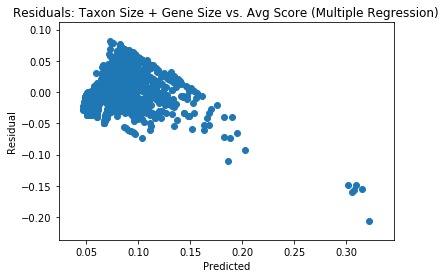

In [13]:
residuals = compute_residuals(ols_results_gene_taxon_avgScores, gene_taxon_avg_scores)
predicted = ols_results_gene_taxon_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size + Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

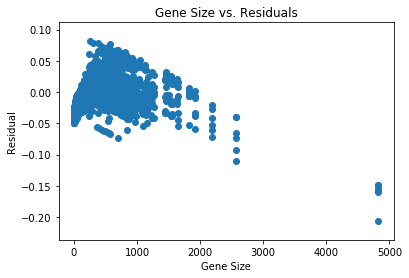

In [14]:
plt.scatter(np.array(gene_taxon_avg_scores['gene']), np.array(residuals))
plt.title('Gene Size vs. Residuals')
plt.xlabel('Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

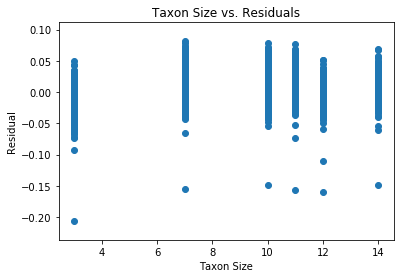

In [15]:
plt.scatter(np.array(gene_taxon_avg_scores['taxon']), np.array(residuals))
plt.title('Taxon Size vs. Residuals')
plt.xlabel('Taxon Size')
plt.ylabel('Residual')

## OLS on log gene profile size, log taxon profile size, average scores.

In [16]:
ols_results_geneLog_taxonLog_avgScores = ols_multiple_regression(geneLog_taxonLog_avg_scores, True, True, False,
                                                            False, False, False)
print(ols_results_geneLog_taxonLog_avgScores.params)
print('R squared '+str(ols_results_geneLog_taxonLog_avgScores.rsquared))
print('Adjusted R squared '+str(ols_results_geneLog_taxonLog_avgScores.rsquared_adj))
print(ols_results_geneLog_taxonLog_avgScores.summary())

Intercept   -0.017575
taxonLog    -0.010117
geneLog      0.020697
dtype: float64
R squared 0.5877198598913216
Adjusted R squared 0.5875089209605932
                            OLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     2786.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:28   Log-Likelihood:                 9933.3
No. Observations:                3912   AIC:                        -1.986e+04
Df Residuals:                    3909   BIC:                        -1.984e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

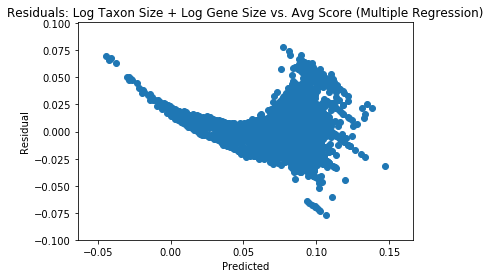

In [17]:
residuals = compute_residuals(ols_results_geneLog_taxonLog_avgScores, geneLog_taxonLog_avg_scores)
predicted = ols_results_geneLog_taxonLog_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

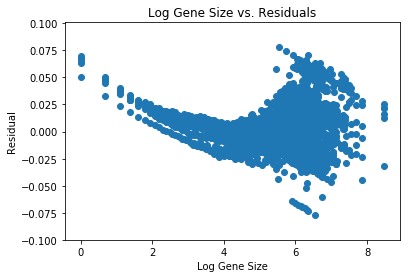

In [18]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

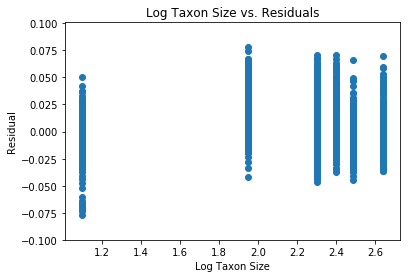

In [19]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## OLS on log gene profile size, log taxon profile size, log average scores.

In [20]:
ols_results_geneLog_taxonLog_avgScoresLog = ols_multiple_regression(geneLog_taxonLog_avg_scoresLog, True, True, True,
                                                               False, False, False)
print(ols_results_geneLog_taxonLog_avgScoresLog.params)
print('R squared '+str(ols_results_geneLog_taxonLog_avgScoresLog.rsquared))
print('Adjusted R squared '+str(ols_results_geneLog_taxonLog_avgScoresLog.rsquared_adj))
print(ols_results_geneLog_taxonLog_avgScoresLog.summary())

Intercept   -4.233184
taxonLog    -0.118803
geneLog      0.328559
dtype: float64
R squared 0.7358272107728412
Adjusted R squared 0.7356920494583223
                            OLS Regression Results                            
Dep. Variable:          avg_scoresLog   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     5444.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:28   Log-Likelihood:                 474.38
No. Observations:                3912   AIC:                            -942.8
Df Residuals:                    3909   BIC:                            -923.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

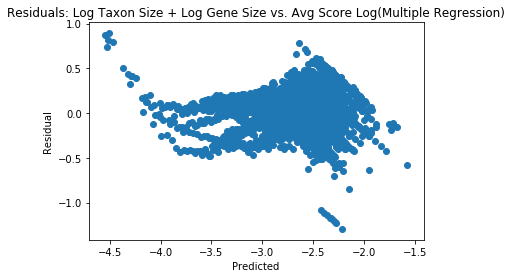

In [21]:
residuals = compute_residuals(ols_results_geneLog_taxonLog_avgScoresLog, geneLog_taxonLog_avg_scoresLog)
predicted = ols_results_geneLog_taxonLog_avgScoresLog.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score Log(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

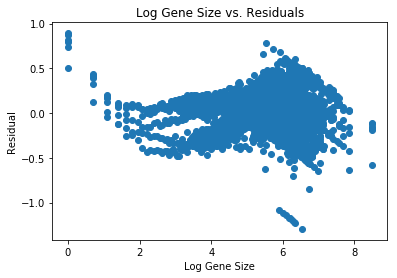

In [22]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

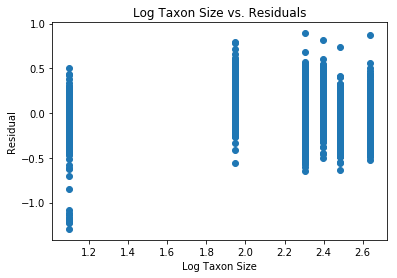

In [23]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## OLS on box cox gene profile size, box cox taxon profile size, average scores.

In [24]:
ols_results_geneBoxCox_taxonBoxCox_avgScores = ols_multiple_regression(geneBoxCox_taxonBoxCox_avg_scores, 
                                                                   False, False, False, True, True, False)
print(ols_results_geneBoxCox_taxonBoxCox_avgScores.params)
print('R squared '+str(ols_results_geneBoxCox_taxonBoxCox_avgScores.rsquared))
print('Adjusted R squared '+str(ols_results_geneBoxCox_taxonBoxCox_avgScores.rsquared_adj))
print(ols_results_geneBoxCox_taxonBoxCox_avgScores.summary())

Intercept      0.024774
taxonBoxCox   -0.000661
geneBoxCox     0.003830
dtype: float64
R squared 0.6436595674873768
Adjusted R squared 0.643477249537767
                            OLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     3530.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:29   Log-Likelihood:                 10219.
No. Observations:                3912   AIC:                        -2.043e+04
Df Residuals:                    3909   BIC:                        -2.041e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|  

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

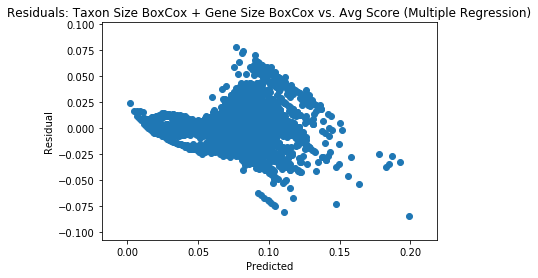

In [25]:
residuals = compute_residuals(ols_results_geneBoxCox_taxonBoxCox_avgScores, geneBoxCox_taxonBoxCox_avg_scores)
predicted = ols_results_geneBoxCox_taxonBoxCox_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

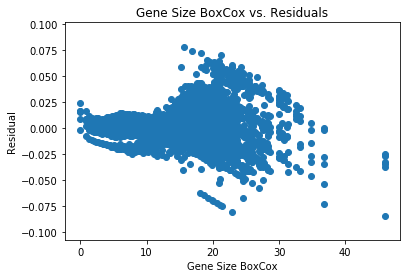

In [26]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

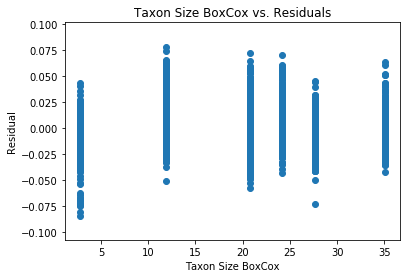

In [27]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## OLS on box cox gene profile size, box cox taxon profile size, box cox average scores.

In [28]:
ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox = ols_multiple_regression(geneBoxCox_taxonBoxCox_avg_scoresBoxCox, 
                                                                   False, False, False, True, True, True)
print(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.params)
print('R squared '+str(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.rsquared))
print('Adjusted R squared '+str(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.rsquared_adj))
print(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.summary())

Intercept     -1.829335
taxonBoxCox   -0.002741
geneBoxCox     0.017775
dtype: float64
R squared 0.6895847710376939
Adjusted R squared 0.6894259502502995
                            OLS Regression Results                            
Dep. Variable:       avg_scoresBoxCox   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     4342.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:29   Log-Likelihood:                 4651.9
No. Observations:                3912   AIC:                            -9298.
Df Residuals:                    3909   BIC:                            -9279.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t| 

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

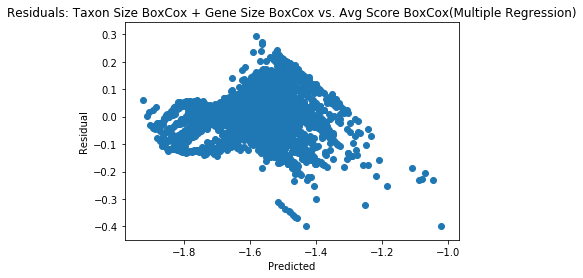

In [29]:
residuals = compute_residuals(ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox, geneBoxCox_taxonBoxCox_avg_scoresBoxCox)
predicted = ols_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score BoxCox(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

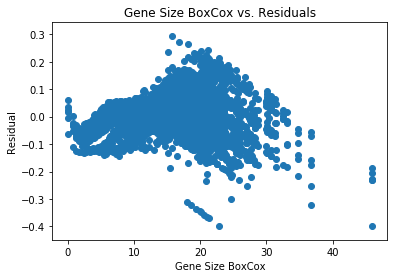

In [30]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

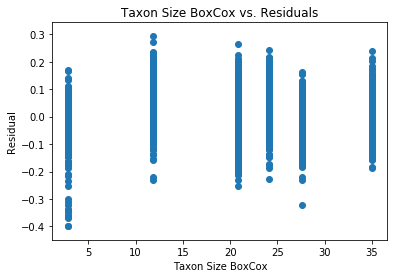

In [31]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## WLS Multi Regression

For the weights of each data point we will use the number of times the pair (gene profile size, taxon profile size) appears in the data set. That should be relevant thowards how important that data point is for the overall data and modeling.

## Computing pair count (taxon, gene)-score

In [32]:
gene_taxon_pair_count = gene_taxon_scores.groupby(['taxon','gene']).size().reset_index(name='count')
print(gene_taxon_pair_count.head())

   taxon  gene  count
0      3     1    480
1      3     2    818
2      3     3    487
3      3     4    450
4      3     5    307


In [54]:
def wls_multiple_regression(input_data):
    
    if input_data is None:
        return               
        
    y = input_data.iloc[:,2]   
    X = input_data[input_data.columns[0:2]]        
    X = sm.add_constant(X)
    results = smf.WLS(y, X, weights = gene_taxon_pair_count.loc[:,'count']).fit()
    return results    

## WLS on gene profile size, taxon profile size, average scores.

In [55]:
wls_results_gene_taxon_avgScores = wls_multiple_regression(gene_taxon_avg_scores)
print(wls_results_gene_taxon_avgScores.params)
print('R squared '+str(wls_results_gene_taxon_avgScores.rsquared))
print('Adjusted R squared '+str(wls_results_gene_taxon_avgScores.rsquared_adj))
print(wls_results_gene_taxon_avgScores.summary())

const    0.031567
taxon   -0.000296
gene     0.000120
dtype: float64
R squared 0.6251478661537209
Adjusted R squared 0.6249560768808397
                            WLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.625
Model:                            WLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     3260.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:55:12   Log-Likelihood:                 8737.8
No. Observations:                3912   AIC:                        -1.747e+04
Df Residuals:                    3909   BIC:                        -1.745e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

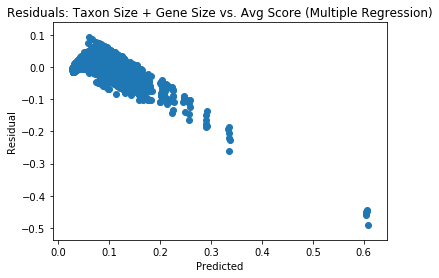

In [56]:
residuals = compute_residuals(wls_results_gene_taxon_avgScores, gene_taxon_avg_scores)
predicted = wls_results_gene_taxon_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size + Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

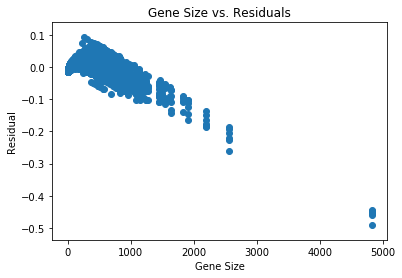

In [57]:
plt.scatter(np.array(gene_taxon_avg_scores['gene']), np.array(residuals))
plt.title('Gene Size vs. Residuals')
plt.xlabel('Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

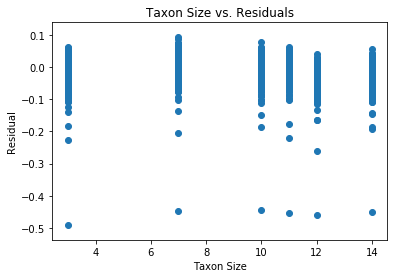

In [58]:
plt.scatter(np.array(gene_taxon_avg_scores['taxon']), np.array(residuals))
plt.title('Taxon Size vs. Residuals')
plt.xlabel('Taxon Size')
plt.ylabel('Residual')

## WLS on log gene profile size, log taxon profile size, average scores.

In [59]:
wls_results_geneLog_taxonLog_avgScores = wls_multiple_regression(geneLog_taxonLog_avg_scores)
print(wls_results_geneLog_taxonLog_avgScores.params)
print('R squared '+str(wls_results_geneLog_taxonLog_avgScores.rsquared))
print('Adjusted R squared '+str(wls_results_geneLog_taxonLog_avgScores.rsquared_adj))
print(wls_results_geneLog_taxonLog_avgScores.summary())

const       0.004534
taxonLog   -0.001067
geneLog     0.010885
dtype: float64
R squared 0.7116788076212535
Adjusted R squared 0.7115312910224412
                            WLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.712
Model:                            WLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     4824.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:55:20   Log-Likelihood:                 9251.1
No. Observations:                3912   AIC:                        -1.850e+04
Df Residuals:                    3909   BIC:                        -1.848e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.02

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

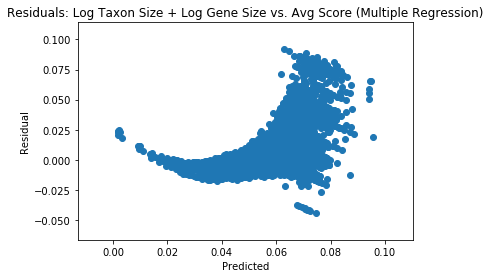

In [60]:
residuals = compute_residuals(wls_results_geneLog_taxonLog_avgScores, geneLog_taxonLog_avg_scores)
predicted = wls_results_geneLog_taxonLog_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

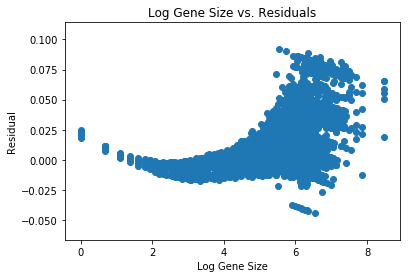

In [61]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

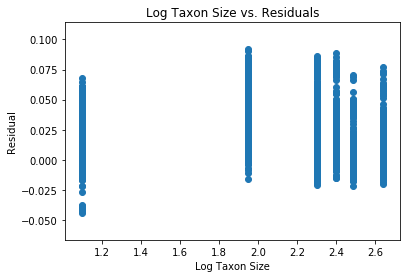

In [62]:
plt.scatter(np.array(geneLog_taxonLog_avg_scores['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## WLS on log gene profile size, log taxon profile size, log average scores.

In [63]:
wls_results_geneLog_taxonLog_avgScoresLog = wls_multiple_regression(geneLog_taxonLog_avg_scoresLog)
print(wls_results_geneLog_taxonLog_avgScoresLog.params)
print('R squared '+str(wls_results_geneLog_taxonLog_avgScoresLog.rsquared))
print('Adjusted R squared '+str(wls_results_geneLog_taxonLog_avgScoresLog.rsquared_adj))
print(wls_results_geneLog_taxonLog_avgScoresLog.summary())

const      -4.292265
taxonLog   -0.004789
geneLog     0.276369
dtype: float64
R squared 0.7903061745733417
Adjusted R squared 0.7901988868652697
                            WLS Regression Results                            
Dep. Variable:          avg_scoresLog   R-squared:                       0.790
Model:                            WLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     7366.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:55:27   Log-Likelihood:                -2571.8
No. Observations:                3912   AIC:                             5150.
Df Residuals:                    3909   BIC:                             5168.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.02

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

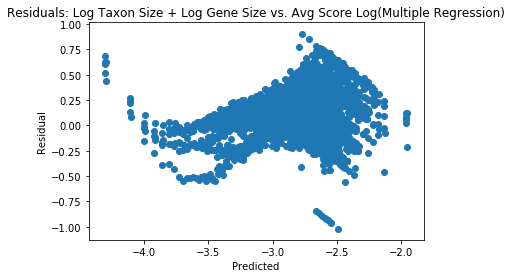

In [64]:
residuals = compute_residuals(wls_results_geneLog_taxonLog_avgScoresLog, geneLog_taxonLog_avg_scoresLog)
predicted = wls_results_geneLog_taxonLog_avgScoresLog.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Avg Score Log(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

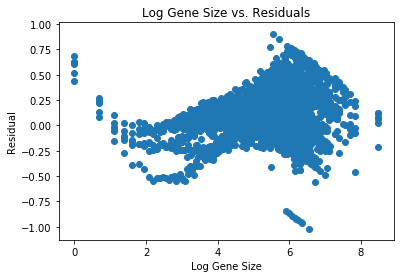

In [65]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

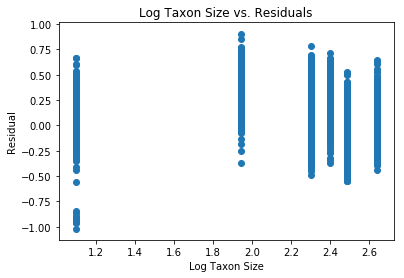

In [66]:
plt.scatter(np.array(geneLog_taxonLog_avg_scoresLog['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## WLS on box cox gene profile size, box cox taxon profile size, average scores.

In [67]:
wls_results_geneBoxCox_taxonBoxCox_avgScores = wls_multiple_regression(geneBoxCox_taxonBoxCox_avg_scores)
print(wls_results_geneBoxCox_taxonBoxCox_avgScores.params)
print('R squared '+str(wls_results_geneBoxCox_taxonBoxCox_avgScores.rsquared))
print('Adjusted R squared '+str(wls_results_geneBoxCox_taxonBoxCox_avgScores.rsquared_adj))
print(wls_results_geneBoxCox_taxonBoxCox_avgScores.summary())

const          0.014359
taxonBoxCox   -0.000118
geneBoxCox     0.003673
dtype: float64
R squared 0.8472084321989388
Adjusted R squared 0.8471302579508952
                            WLS Regression Results                            
Dep. Variable:             avg_scores   R-squared:                       0.847
Model:                            WLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                 1.084e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:55:34   Log-Likelihood:                 10493.
No. Observations:                3912   AIC:                        -2.098e+04
Df Residuals:                    3909   BIC:                        -2.096e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t| 

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

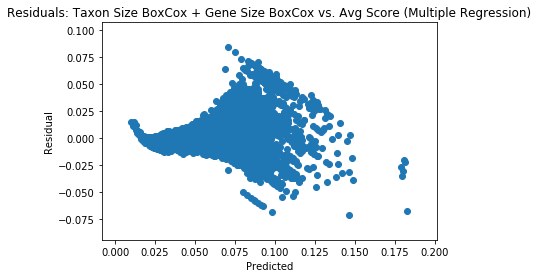

In [68]:
residuals = compute_residuals(wls_results_geneBoxCox_taxonBoxCox_avgScores, geneBoxCox_taxonBoxCox_avg_scores)
predicted = wls_results_geneBoxCox_taxonBoxCox_avgScores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

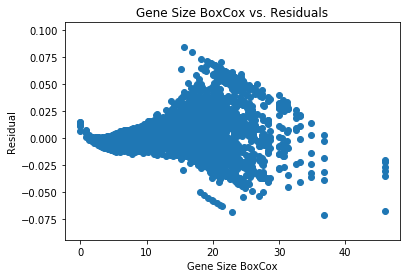

In [69]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

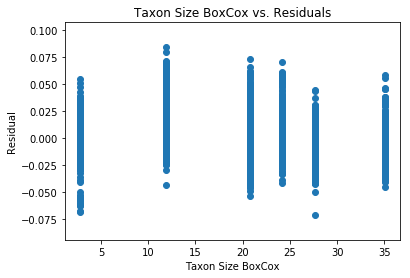

In [70]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scores['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## WLS on box cox gene profile size, box cox taxon profile size, box cox average scores.

In [71]:
wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox = wls_multiple_regression(geneBoxCox_taxonBoxCox_avg_scoresBoxCox)
print(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.params)
print('R squared '+str(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.rsquared))
print('Adjusted R squared '+str(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.rsquared_adj))
print(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.summary())

const         -1.938113
taxonBoxCox   -0.000546
geneBoxCox     0.022443
dtype: float64
R squared 0.8593579526206722
Adjusted R squared 0.859285994550895
                            WLS Regression Results                            
Dep. Variable:       avg_scoresBoxCox   R-squared:                       0.859
Model:                            WLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 1.194e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:55:41   Log-Likelihood:                 3606.2
No. Observations:                3912   AIC:                            -7206.
Df Residuals:                    3909   BIC:                            -7188.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|  

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

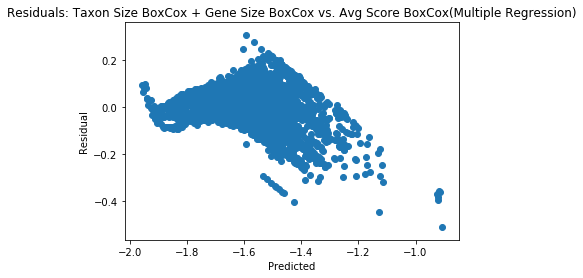

In [72]:
residuals = compute_residuals(wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox, geneBoxCox_taxonBoxCox_avg_scoresBoxCox)
predicted = wls_results_geneBoxCox_taxonBoxCox_avgScoresBoxCox.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Avg Score BoxCox(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

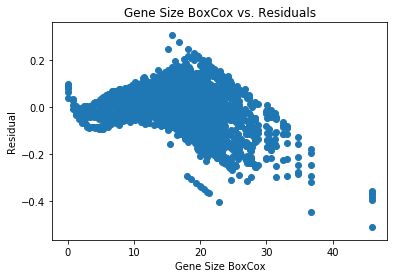

In [73]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

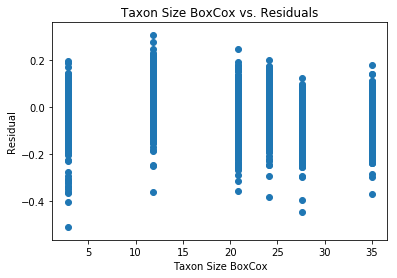

In [74]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_avg_scoresBoxCox['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')